In [2]:
import cv2
import dlib
import numpy as np
import pywt
import os
import math 
import imutils
from imutils import face_utils

from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
%matplotlib inline

# Download Jaffe Database & dlib landmarks detection model

1- Download the database from the following link:
    http://www.kasrl.org/jaffe.html

2- Download dlib landmarks detection model from the following link:
    http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
    then unzip the file
    
you should set the paths in the following cell to the ones you downloaded:

In [ ]:
jaffe_dir_path = R"/jaffedbase/jaffe/"
landmarks_predictor_model = R"/shape_predictor_68_face_landmarks.dat"

In [3]:
# 7 expressions: [neutral, happy, angry, disgust, fear, sad, surprise]
expres_code = ['NE','HA','AN','DI','FE','SA','SU']
expressions = [ 0,   1,   2,   3,   4,   5,   6]

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(landmarks_predictor_model)

In [5]:
def read_data(dir_path):
    img_names = []
    img_data_list = []
    labels = []
    img_list = os.listdir(dir_path)
    for img in img_list:
        input_img = cv2.imread(dir_path + img, cv2.IMREAD_GRAYSCALE)
        img_data_list.append(input_img)
        label = img[3:5]  # each name of image have 2 char for label from index 3-5
        labels.append(expres_code.index(label))
        img_names.append(img)
    img_data = np.array(img_data_list)

    print(img_data.shape)
    return img_data, labels, img_names

def rotateImage(image, angle):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result

def angle_line_x_axis(point1, point2):
    angle_r = math.atan2(point1[1] - point2[1], point1[0] - point2[0]);
    angle_degree = angle_r * 180 / math.pi;
    return angle_degree

def detect_eyes(gray):
    rects = detector(gray, 1)
    # loop over the face detections
    for (i, rect) in enumerate(rects):
        # determine the facial landmarks for the face region, then
        # convert the landmark (x, y)-coordinates to a NumPy array
        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape)
        
        pts_right = shape[36 : 42]   # right eye landmarks
        pts_left = shape[42 : 48]    # left eye landmarks
        
        hull_right = cv2.convexHull(pts_right)
        M_right = cv2.moments(hull_right)
        # calculate x,y coordinate of center
        cX_right = int(M_right["m10"] / M_right["m00"])
        cY_right = int(M_right["m01"] / M_right["m00"])
        right_eye_center = (cX_right, cY_right)
        
        hull_left = cv2.convexHull(pts_left)
        M_left = cv2.moments(hull_left)
        # calculate x,y coordinate of center
        cX_left = int(M_left["m10"] / M_left["m00"])
        cY_left = int(M_left["m01"] / M_left["m00"])
        left_eye_center = (cX_left, cY_left)

    return left_eye_center, right_eye_center

def preprocessing(input_images):
    normalized_faces = []
    for gray in input_images:
        left_eye, rigth_eye = detect_eyes(gray)
        
        angle = angle_line_x_axis(left_eye, rigth_eye)
        rotated_img = rotateImage(gray, angle)
        
        # line length
        D = cv2.norm(np.array(left_eye) - np.array(rigth_eye))
        
        # center of the line
        D_point = [(left_eye[0] + rigth_eye[0]) / 2, (left_eye[1] + rigth_eye[1]) / 2]
        
        # Face ROI
        x_point = int(D_point[0] - (0.9 * D))
        y_point = int(D_point[1] - (0.6 * D))
        width_point = int(1.8 * D)
        height_point = int(2.2 * D)
        r = [x_point, y_point, width_point, height_point]
        face_roi = rotated_img[int(r[1]):int(r[1]+r[3]), int(r[0]):int(r[0]+r[2])]
        
        # resize to (96, 128)
        face_roi = cv2.resize(face_roi,(96,128))
        
        # Equalize Hist
        face_roi = cv2.equalizeHist(face_roi)
        normalized_faces.append(face_roi)
    return normalized_faces

def apply_wavelet_transform(images):
    normalized_faces = []
    for img in images:
        coeffs2 = pywt.dwt2(img, 'bior1.3')
        LL, (LH, HL, HH) = coeffs2
        normalized_faces.append(LL)
    return normalized_faces

def from_2d_to_1d(images):
    normalized_faces = []
    for img in images:
        tmp = img.reshape(-1)
        normalized_faces.append(tmp)
    faces_1d = np.array(normalized_faces)
    return faces_1d

# 1. Preprocessing

In [ ]:
X, Y, img_names = read_data(jaffe_dir_path)
cropped_X = preprocessing(X)

# Draw the output of the preprocessing step

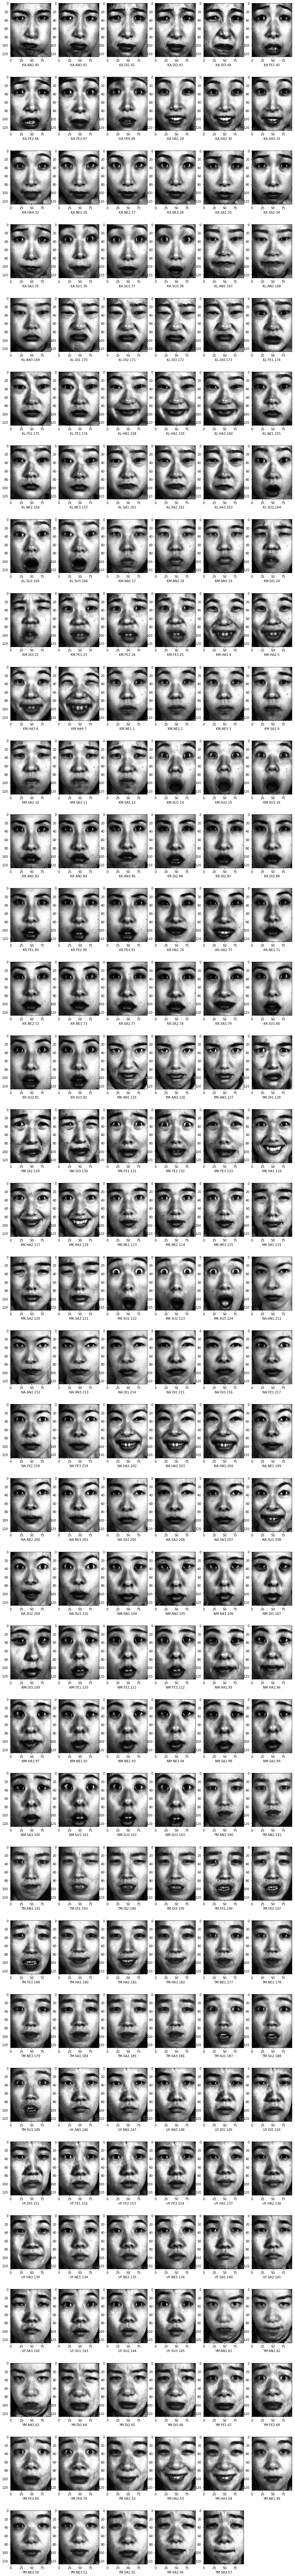

In [125]:
w=10
h=10
fig=plt.figure(figsize=(16, 150))
columns = 6
rows = int(len(cropped_X)/columns)
for i in range(1, columns*rows):
    img = cropped_X[i]
    ax = fig.add_subplot(rows, columns, i)
    type_name = img_names[i][:-5]
    ax.set_xlabel(type_name)
    plt.imshow(img, cmap = 'gray')
plt.show()

# 2. Feature extraction

In [8]:
LL_images = apply_wavelet_transform(cropped_X)
X_new = from_2d_to_1d(LL_images)
print(X_new.shape)

(213, 3300)


In [9]:
scaler = StandardScaler()
scaler.fit(X_new)
scaled_data = scaler.transform(X_new)

pca = PCA(n_components=35, whiten=False)
pca.fit(scaled_data)

X_tr, X_ts, y_tr, y_ts = train_test_split(scaled_data, Y, test_size=0.20, random_state=4)
X_tr_pca = pca.transform(X_tr)

# Expression classification (SVM)

In [ ]:
# get best parameters for svm by GridSearch
param_grid = { "C" : [0.1, 1, 10] , "gamma" : [1, 0.1, 0.01]}
gs = GridSearchCV(estimator=SVC(kernel='linear'), param_grid=param_grid, scoring='accuracy', refit=True, verbose=2)
gs = gs.fit(X_tr_pca, y_tr)

print(gs.best_score_)
print(gs.best_params_)

In [119]:
bp = gs.best_params_
model = SVC(C=bp['C'], kernel='linear', gamma=bp['gamma'])
model.fit(X_tr_pca, y_tr)

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=1, kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [127]:
X_ts_pca = pca.transform(X_ts)
mean_accuracy = model.score(X_ts_pca, y_ts)
predictions = model.predict(X_ts_pca)

In [128]:
print(mean_accuracy)
print('\n')
print(confusion_matrix(y_ts,predictions))
print('\n')
print(classification_report(y_ts,predictions))

0.9302325581395349


[[4 0 0 0 0 0 0]
 [0 9 0 0 0 0 0]
 [0 0 8 0 0 0 0]
 [0 0 0 6 0 1 0]
 [0 0 0 0 5 1 0]
 [0 1 0 0 0 5 0]
 [0 0 0 0 0 0 3]]


             precision    recall  f1-score   support

          0       1.00      1.00      1.00         4
          1       0.90      1.00      0.95         9
          2       1.00      1.00      1.00         8
          3       1.00      0.86      0.92         7
          4       1.00      0.83      0.91         6
          5       0.71      0.83      0.77         6
          6       1.00      1.00      1.00         3

avg / total       0.94      0.93      0.93        43



# Drawing only 2 components of PCA

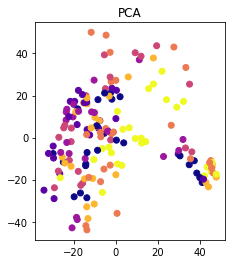

In [113]:
from matplotlib import offsetbox
from sklearn import manifold

def plot_2_components(Xp, title):
    plt.figure()
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(Xp[:,0], Xp[:,1], c=np.array(y_tr)/7.,cmap='plasma')
    plt.title(title)

    
X_pca_2components = PCA(n_components=2).fit_transform(X_tr)
plot_2_components(X_pca_2components, "PCA")
plt.show()

In [ ]:
# Testing TSNE instead of PCA
X_tsne_2components = manifold.TSNE(n_components=2, init='pca').fit_transform(X_tr)
plot_2_components(X_tsne_2components,"t-SNE")
plt.show()